In [1]:
import shapely
import shapely.vectorized

from itertools import product, combinations

from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import geopy
import geopy.distance
import xarray as xr
import seaborn as sns
import geopandas

import cartopy.io.shapereader as shpreader

import numpy as np

import pandas as pd

In [2]:
df = pd.read_csv('../data/category_predictions.csv')
df.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - Water availability - k_prediction,6 - Water availability - k_prediction_binary,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,Northeastern Tibetan Plateau; Tree-ring width;...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,NaN,NaN,1.000000,0.000000,1.0,1.000000,0.333333,0.471405,0.0,0.804738
2,2,1344242,This study examines the spatial and temporal p...,GIS analysis of spatial and temporal patterns ...,fire; geographic information systems; manageme...,['Forestry'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,NaN,NaN,0.166667,0.372678,0.0,0.539345,1.000000,0.000000,1.0,1.000000
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
geos = pd.read_csv('../data/geo_df.csv')
geos = geos.drop_duplicates(["doc_id","geonameid"])
print(geos.shape)
geos.head()

(105576, 9)


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id
0,NaN,39.76000,-98.5000,USA,6252001,United States,A,PCLI,3305893
1,NaN,22.00000,79.0000,IND,1269750,Republic of India,A,PCLI,1477550
2,NaN,60.00000,100.0000,RUS,2017370,Russian Federation,A,PCLI,1477550
3,Punjab,31.47060,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,SCHC,1477550
4,NaN,3.51342,-132.1875,NaN,2363254,Pacific Ocean,H,OCN,1477550


In [58]:
from operator import itemgetter
import ast

places = pd.read_csv('../data/place_df.csv')

places.head()

,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code,geonameid,place_name,feature_class
0,0,United States,"[{'start': 427, 'end': 440}]",USA,0.999811,"{'admin1': 'NA', 'lat': '39.76', 'lon': '-98.5...",3305893,39.76,-98.5,PCLI,6252001,United States,A
1,3,India,"[{'start': 140, 'end': 145}]",IND,0.999398,"{'admin1': 'NA', 'lat': '22', 'lon': '79', 'co...",1477550,22.00,79.0,PCLI,1269750,Republic of India,A
2,4,Russia,"[{'start': 697, 'end': 703}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.00,100.0,PCLI,2017370,Russian Federation,A
3,5,Pakistan,"[{'start': 763, 'end': 771}]",PAK,0.989610,"{'admin1': 'Punjab', 'lat': '31.4706', 'lon': ...",1477550,30.00,70.0,PCLI,1168579,Islamic Republic of Pakistan,A
4,7,Russia,"[{'start': 983, 'end': 989}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.00,100.0,PCLI,2017370,Russian Federation,A


In [61]:
df_places = pd.merge(df,places,left_on="id",right_on="doc_id")
df_places.head()

,Unnamed: 0_x,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code,geonameid,place_name,feature_class
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.999764,"{'admin1': 'NA', 'lat': '35', 'lon': '105', 'c...",136746,35.00,105.00,PCLI,1814991,People’s Republic of China,A
1,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.993103,"{'admin1': 'Qinghai', 'lat': '36', 'lon': '96'...",136746,36.00,96.00,ADM1,1280239,Qinghai Sheng,A
2,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.993103,"{'admin1': 'Inner Mongolia', 'lat': '43.5', 'l...",136746,43.50,114.75,ADM1,2035607,Inner Mongolia Autonomous Region,A
3,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.993103,{'admin1': 'Xinjiang Uyghur Autonomous Region'...,136746,41.50,85.50,ADM1,1529047,Xinjiang Uygur Zizhiqu,A
4,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,CHN,0.993103,"{'admin1': 'Gansu', 'lat': '37.75', 'lon': '10...",136746,37.75,102.75,ADM1,1810676,Gansu Sheng,A


## Load the D&A datasets for precip

In [62]:
df_1901_2010=xr.open_dataset('../data/d_a/9cat.190101-201012.nc').roll(LON=72, roll_coords=True)
df_1951_2010=xr.open_dataset('../data/d_a/9cat.195101-201012.nc').roll(LON=72, roll_coords=True)
df_1981_2010=xr.open_dataset('../data/d_a/9cat.198101-201012.nc').roll(LON=72, roll_coords=True)
arr_1901_2010=np.zeros([72, 144])
arr_1951_2010=np.zeros([72, 144])
arr_1981_2010=np.zeros([72, 144])

df_1951_2010.LON

<xarray.DataArray 'LON' (LON: 144)>
array([181.25, 183.75, 186.25, 188.75, 191.25, 193.75, 196.25, 198.75, 201.25,
       203.75, 206.25, 208.75, 211.25, 213.75, 216.25, 218.75, 221.25, 223.75,
       226.25, 228.75, 231.25, 233.75, 236.25, 238.75, 241.25, 243.75, 246.25,
       248.75, 251.25, 253.75, 256.25, 258.75, 261.25, 263.75, 266.25, 268.75,
       271.25, 273.75, 276.25, 278.75, 281.25, 283.75, 286.25, 288.75, 291.25,
       293.75, 296.25, 298.75, 301.25, 303.75, 306.25, 308.75, 311.25, 313.75,
       316.25, 318.75, 321.25, 323.75, 326.25, 328.75, 331.25, 333.75, 336.25,
       338.75, 341.25, 343.75, 346.25, 348.75, 351.25, 353.75, 356.25, 358.75,
         1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,  21.25,
        23.75,  26.25,  28.75,  31.25,  33.75,  36.25,  38.75,  41.25,  43.75,
        46.25,  48.75,  51.25,  53.75,  56.25,  58.75,  61.25,  63.75,  66.25,
        68.75,  71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25,  88.75,
        91.25,  93.75,  96.25,  98.75, 101.25, 103.75, 106.25, 108.75, 111.25,
       113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75,
       136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25,
       158.75, 161.25, 163.75, 166.25, 168.75, 171.25, 173.75, 176.25, 178.75])
Coordinates:
  * LON      (LON) float64 181.2 183.8 186.2 188.8 ... 171.2 173.8 176.2 178.8
Attributes:
    long_name:      Longitude
    units:          degrees_east
    axis:           X
    modulo:         360.0
    point_spacing:  even
    standard_name:  longitude

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/cartopy/mpl/ticker.py:476: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: dms
  MaxNLocator.set_params(self, **kwargs)


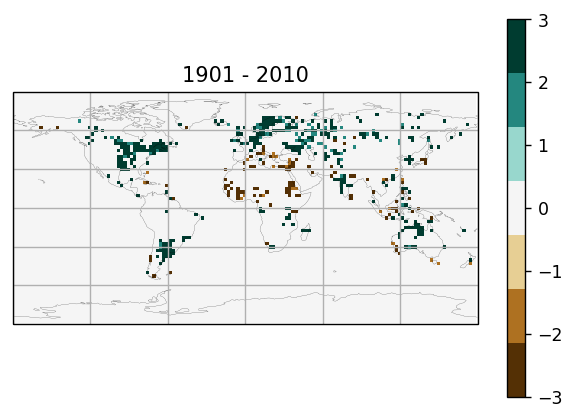

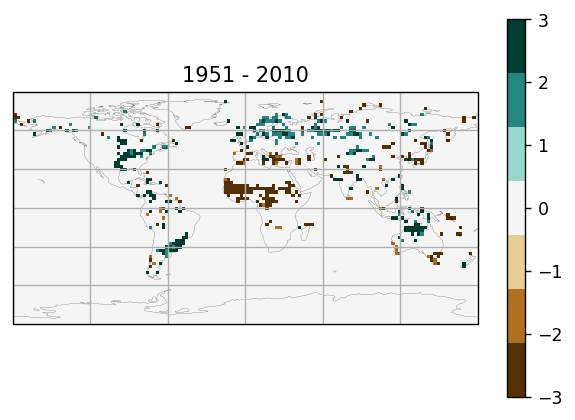

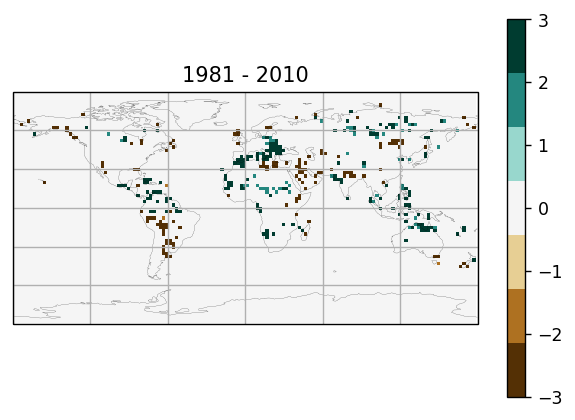

In [63]:
original_values = [4,3,2,1,0,-1,-2,-3,-4]
arr_vars = ["CP4","CP3","CP2","CP1","CP0","CM1","CM2","CM3","CM4"]
simplified_values = [3,3,2,1,0,-1,-2,-3,-3]
arrs = [arr_1901_2010, arr_1951_2010,arr_1981_2010]
dfs = [df_1901_2010, df_1951_2010, df_1981_2010]
labels = ["1901 - 2010", "1951 - 2010", "1981 - 2010"]


for arr, df_2010, label in zip(arrs, dfs, labels):
    df_2010 = df_2010.to_dataframe()
    for o_v, s_v, arr_var in zip(original_values, simplified_values, arr_vars):       
        arr[(df_2010[arr_var].values==o_v).reshape(72, 144)]=s_v
        df_2010.loc[df_2010[arr_var].values==o_v, "da_cat"] = s_v
        
    fig, ax = plt.subplots(dpi=125)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.gridlines(lw=0.1)

    mesh=ax.pcolormesh(df_1901_2010.LON.values,df_1901_2010.LAT.values,arr,cmap=plt.cm.get_cmap('BrBG',7), vmin=-3, vmax=3)
    ax.set_title(label)
    plt.colorbar(mesh)
    plt.show()
        
        

In [64]:
df_1951_2010 = df_1951_2010.to_dataframe()
for o_v, s_v, arr_var in zip(original_values, simplified_values, arr_vars):       
    arr[(df_1951_2010[arr_var].values==o_v).reshape(72, 144)]=s_v
    df_1951_2010.loc[df_1951_2010[arr_var].values==o_v, "da_cat"] = s_v
df_1951_2010 = df_1951_2010.reset_index()

In [65]:
df_places['LAT'] = df_places['lat']//2.5*2.5+1.25
df_places['LON'] = df_places['lon']//2.5*2.5+1.25
precip = df_places[
    (df_places['6 - Precipitation - mean_prediction']>0.5)
]
lon_df, lat_df = np.meshgrid(df_1951_2010.LON.unique(),df_1951_2010.LAT.unique())
n = precip.groupby(['LAT','LON']).size().to_frame("n_studies").reset_index()
#n.loc
n.loc[n['LON']<0,"LON"] = n.loc[n['LON']<0,"LON"] + 360
#n['LON'] = n['LON'] + 180

ndf = (
    pd.DataFrame({"LAT": lat_df.ravel(), "LON": lon_df.ravel()})
    .merge(n,how="left")
    .fillna(0)
    .merge(df_1951_2010.reset_index()[["LAT","LON","da_cat"]])
)

ndf.head()


,LAT,LON,n_studies,da_cat
0,-88.75,181.25,0.0,NaN
1,-88.75,183.75,0.0,NaN
2,-88.75,186.25,0.0,NaN
3,-88.75,188.75,0.0,NaN
4,-88.75,191.25,0.0,NaN


In [66]:
ndf.loc[(ndf['n_studies']==0),"n_study_group"] = 0
ndf.loc[(ndf['n_studies']>0) & (ndf['n_studies']<11),"n_study_group"] = 1
ndf.loc[(ndf['n_studies']>10) & (ndf['n_studies']<101),"n_study_group"] = 2
ndf.loc[(ndf['n_studies']>100) & (ndf['n_studies']<1001),"n_study_group"] = 3

In [67]:
ndf_sum = (
    ndf.groupby(['da_cat','n_study_group'])
    .size()
    .to_frame("n")
    .reset_index()
    .pivot_table(values="n",index="da_cat",columns="n_study_group")
)
ndf_sum

n_study_group,0.0,1.0,2.0,3.0
da_cat,,,,
-3.0,142.0,50.0,5.0,NaN
-2.0,22.0,12.0,1.0,NaN
0.0,904.0,409.0,109.0,5.0
2.0,87.0,18.0,10.0,NaN
3.0,131.0,47.0,16.0,NaN


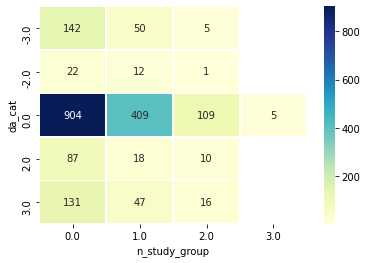

In [68]:
sns.heatmap(data=ndf_sum,cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


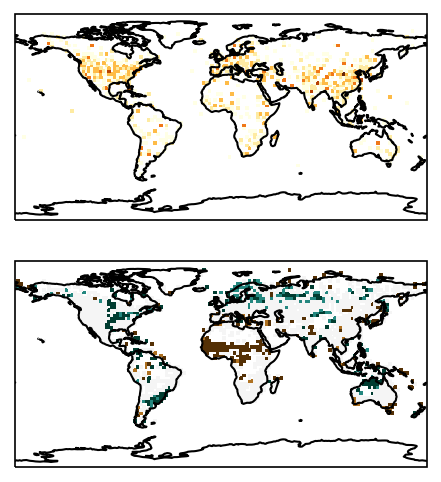

In [69]:



plt.figure(dpi=150)

ax = plt.subplot(2,1,1,projection=ccrs.PlateCarree())

n = np.array(ndf.n_studies).reshape(72,144)
n[n==0] = np.nan

ax.coastlines()
mesh = ax.pcolormesh(
    ndf.LON.unique(),
    ndf.LAT.unique(),
    n,
    norm = mpl.colors.LogNorm(vmin=1, vmax=1000),
    cmap=plt.cm.get_cmap('YlOrBr',6), 
    #vmin=-4, vmax=4
)
cbar = fig.colorbar(mesh)

ax = plt.subplot(2,1,2,projection=ccrs.PlateCarree())


n = np.array(ndf.da_cat).reshape(72,144)
ax.coastlines()
mesh = ax.pcolormesh(
    ndf.LON.unique(),
    ndf.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('BrBG',7), vmin=-3, vmax=3
)
cbar = fig.colorbar(mesh)


In [70]:
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)

yv, xv = np.meshgrid(ndf.LAT.unique(), ndf.LON.unique())
xv[xv>180] = xv[xv>180] - 360

cn = np.zeros([72, 144])

precip_countries = precip[precip["feature_code"]=="PCLI"]

for country in reader.records():
    incountry = shapely.vectorized.contains(country.geometry,xv,yv)
    idx = np.argwhere(incountry==True)
    ndots = idx.size/2
    cdf = precip_countries[precip_countries["country_predicted"]==country.attributes["SU_A3"]]
    for point in idx:
        cn[point[1],point[0]] = 1

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


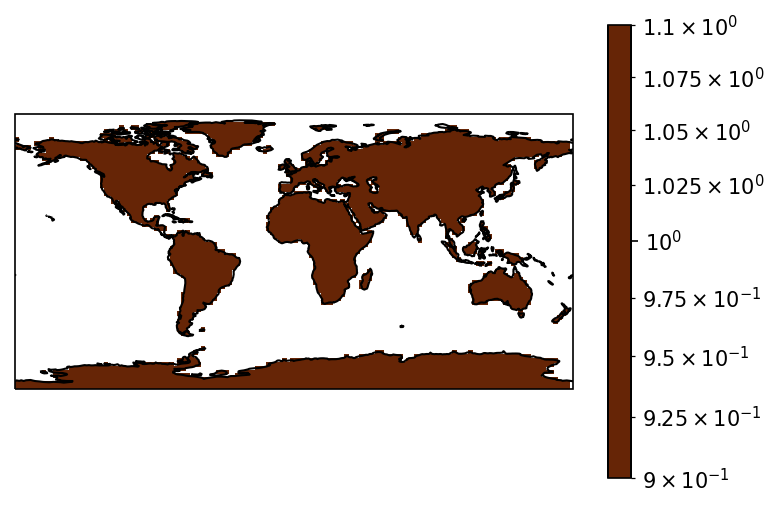

In [15]:
degrees=2.5

plt.figure(dpi=150)

ax = plt.axes(projection=ccrs.PlateCarree())
cn[cn==0] = np.nan

ax.coastlines()
mesh = ax.pcolormesh(
    ndf.LON.unique()-degrees*.5,
    ndf.LAT.unique()-degrees*.5,
    cn,
    norm = mpl.colors.LogNorm(vmin=1, vmax=1),
    cmap = plt.cm.get_cmap('YlOrBr',1), 
)
cbar = plt.colorbar(mesh)

In [74]:
ndf["evidence_cat"] = np.nan

ndf.loc[
    (abs(ndf['da_cat'])>1) & (ndf['n_study_group']>0),"evidence_cat"
] = 1
ndf.loc[
    (abs(ndf['da_cat'])>1) & (ndf['n_study_group']==0),"evidence_cat"
] = 2

ndf.loc[
    (abs(ndf['da_cat'])==1) & (ndf['n_study_group']>0),"evidence_cat"
] = 5
ndf.loc[
    (abs(ndf['da_cat'])==1) & (ndf['n_study_group']==0),"evidence_cat"
] = 6

ndf.loc[
    (abs(ndf['da_cat'])==0) & (ndf['n_study_group']>0),"evidence_cat"
] = 3

ndf.loc[
    (abs(ndf['da_cat'])==0) & (ndf['n_study_group']==0),"evidence_cat"
] = 4


In [75]:
precip.groupby('feature_code').size().to_frame("n").reset_index().sort_values('n',ascending=False).head(10)

,feature_code,n
64,PCLI,2743
0,ADM1,1079
71,PPL,703
107,STM,299
2,ADM2,266
58,MTS,185
51,LK,172
72,PPLA,145
15,BLDG,127
42,HTL,111


In [76]:
ndf.groupby("evidence_cat").size()

evidence_cat
1.0    159
2.0    382
3.0    523
4.0    904
dtype: int64

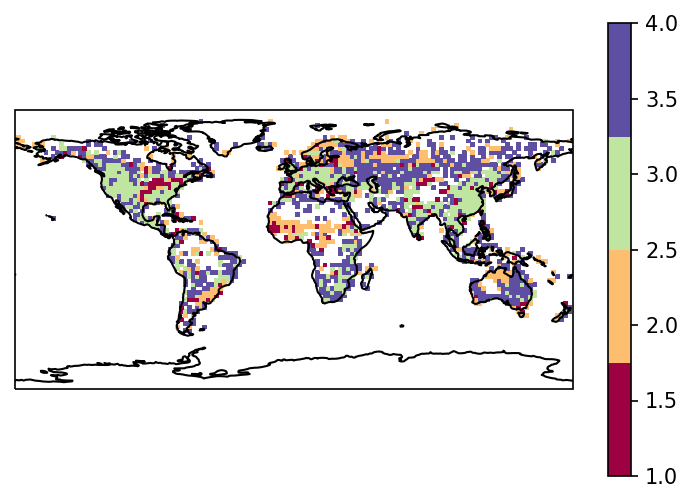

In [77]:
plt.figure(dpi=150)

ax = plt.axes(projection=ccrs.PlateCarree())

n = np.array(ndf.evidence_cat).reshape(72,144)
n[n==0] = np.nan

ax.coastlines()
mesh = ax.pcolormesh(
    ndf.LON.unique(),
    ndf.LAT.unique(),
    n,
    cmap=plt.cm.get_cmap('Spectral',4), 
)
cbar = plt.colorbar(mesh)

- 4 - no d&a, no impacts
- 3 - no d&a, impacts
- 2 - d&a, no impacts
- 1 - d&a, impacts


In [78]:
ndf

,LAT,LON,n_studies,da_cat,n_study_group,evidence_cat
0,-88.75,181.25,0.0,NaN,0.0,NaN
1,-88.75,183.75,0.0,NaN,0.0,NaN
2,-88.75,186.25,0.0,NaN,0.0,NaN
3,-88.75,188.75,0.0,NaN,0.0,NaN
4,-88.75,191.25,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...
10363,88.75,168.75,0.0,NaN,0.0,NaN
10364,88.75,171.25,0.0,NaN,0.0,NaN
10365,88.75,173.75,0.0,NaN,0.0,NaN
10366,88.75,176.25,0.0,NaN,0.0,NaN


In [79]:
country_shapes = geopandas.read_file(shpfilename)
xv[xv>180] = xv[xv>180] - 360
attrib_df = ndf[pd.notna(ndf['da_cat'])]
for i, country in country_shapes.iterrows():
    
    incountry = shapely.vectorized.contains(country.geometry,xv,yv)
    
    idx = np.argwhere(incountry==True)
    ndots = idx.size/2

    n_attributable_trend = 0
    for point in idx:
        lon = ndf.LON.unique()[point[0]]
        lat = ndf.LAT.unique()[point[1]]
        da_cat = attrib_df[(attrib_df['LON']==lon) & (attrib_df['LAT']==lat)]['da_cat']
        if da_cat.shape[0] ==0:
            continue
        
        if abs(da_cat.values[0]) > 1:
            n_attributable_trend +=1
            
    country_shapes.loc[i,'gridcells'] = ndots
    country_shapes.loc[i,'precip_attrib_cells'] = n_attributable_trend
        

In [80]:
country_shapes.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT',
       'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG',
       'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN',
       'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT',
       'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2',
       'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID',
       'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN',
       'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB',
       'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM',
       'MIN_LABEL', 'MAX_LABEL', 'NE_ID', 'WIKIDATAID', 'NAME_AR', 'NAME_BN',
       'NAME_DE', 'NAME_

In [81]:
country_shapes[["ADMIN","ADM0_A3","SOV_A3","gridcells","precip_attrib_cells"]].head()

,ADMIN,ADM0_A3,SOV_A3,gridcells,precip_attrib_cells
0,Fiji,FJI,FJI,0.0,0.0
1,United Republic of Tanzania,TZA,TZA,13.0,0.0
2,Western Sahara,SAH,SAH,3.0,0.0
3,Canada,CAN,CAN,266.0,23.0
4,United States of America,USA,US1,183.0,34.0


In [82]:
nocountry_precip = precip[precip["feature_code"]!="PCLI"]
print(len(precip.doc_id.unique()))
len(nocountry_precip.doc_id.unique())

2469


1762

In [96]:
nocountry_precip.groupby('feature_code').size().sort_values(ascending=False).head(10)

feature_code
ADM1    1079
PPL      703
STM      299
ADM2     266
MTS      185
LK       172
PPLA     145
BLDG     127
HTL      111
PLAT      95
dtype: int64

In [101]:
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_1_states_provinces')

adm1shps = geopandas.read_file(shpfilename)
adm1shps.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
0,Admin-1 scale rank,2,AUS-2651,2651,AU-WA,None,AU,6,Western Australia,None,...,West-AustraliÃ«,Australia Zachodnia,AustrÃ¡lia Ocidental,ÐÐ°Ð¿Ð°Ð´Ð½Ð°Ñ ÐÐ²ÑÑÑÐ°Ð»Ð¸Ñ,Western Australia,BatÄ± Avustralya,TÃ¢y Ãc,è¥¿æ¾³å¤§å©äºå·,1159315805,"MULTIPOLYGON (((113.13181 -25.95199, 113.14823..."
1,Admin-1 scale rank,2,AUS-2650,2650,AU-NT,None,AU,6,Northern Territory,None,...,Noordelijk Territorium,Terytorium PÃ³Ånocne,TerritÃ³rio do Norte,Ð¡ÐµÐ²ÐµÑÐ½Ð°Ñ ÑÐµÑÑÐ¸ÑÐ¾ÑÐ¸Ñ,Northern Territory,Kuzey TopraklarÄ±,LÃ£nh thá» Báº¯c Ãc,åé å°,1159315809,"MULTIPOLYGON (((129.00196 -25.99901, 129.00196..."
2,Admin-1 scale rank,2,AUS-2655,2655,AU-SA,None,AU,3,South Australia,None,...,Zuid-AustraliÃ«,Australia PoÅudniowa,AustrÃ¡lia Meridional,Ð®Ð¶Ð½Ð°Ñ ÐÐ²ÑÑÑÐ°Ð»Ð¸Ñ,South Australia,GÃ¼ney Avustralya,Nam Ãc,åæ¾³å¤§å©äºå·,1159313267,"MULTIPOLYGON (((129.00196 -31.69266, 129.00196..."
3,Admin-1 scale rank,2,AUS-2657,2657,AU-QLD,None,AU,5,Queensland,None,...,Queensland,Queensland,Queensland,ÐÐ²Ð¸Ð½ÑÐ»ÐµÐ½Ð´,Queensland,Queensland,Queensland,æå£«è­å·,1159315807,"MULTIPOLYGON (((138.00196 -25.99901, 138.00174..."
4,Admin-1 scale rank,2,AUS-2660,2660,AU-TAS,None,AU,5,Tasmania,None,...,TasmaniÃ«,Tasmania,TasmÃ¢nia,Ð¢Ð°ÑÐ¼Ð°Ð½Ð¸Ñ,Tasmanien,Tasmanya,Tasmania,å¡æ¯é¦¬å°¼äºå·,1159313261,"MULTIPOLYGON (((147.31246 -43.28038, 147.34238..."


In [103]:
adm1shps.gn_id

0     2058645
1     2064513
2     2061327
3     2152274
4     2147291
       ...   
95    5242283
96    5815135
97    5279468
98    4826850
99    5843591
Name: gn_id, Length: 100, dtype: int64

In [92]:
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='physical',
                                      name='geography_regions_polys')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_geography_regions_polys.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


In [93]:
geography = geopandas.read_file(shpfilename)
geography.head()

,featurecla,name,namealt,region,subregion,min_label,max_label,scalerank,label,wikidataid,...,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,wdid_score,ne_id,geometry
0,Island,Pentecost,None,Oceania,Melanesia,6.7,12.0,7,Pentecost I.,Q960808,...,Pentecost,Pentecostes,ÐÐµÐ½ÑÐµÐºÐ¾ÑÑ,Pentecost Island,None,None,å½­ç¹ç§æ¯ç¹å²,4,1159102327,"POLYGON ((168.22657 -15.98968, 168.20411 -15.9..."
1,Island,Anatom,None,Oceania,Melanesia,6.7,12.0,7,Anatom,Q528884,...,Anatom,Aneytium,ÐÐ½ÐµÐ¹ÑÑÑÐ¼,None,Anatom,None,é¿ç´æå§å³¶,4,1159102329,"POLYGON ((169.83790 -20.24737, 169.82997 -20.2..."
2,Island,Gaua,None,Oceania,Melanesia,6.7,12.0,7,Gaua,Q583383,...,Gaua,Gaua,ÐÐ°ÑÐ°,None,None,None,å ç¦å³¶,4,1159102331,"POLYGON ((167.52491 -14.14214, 167.58619 -14.1..."
3,Island,Utupua,None,Oceania,Melanesia,6.7,12.0,7,Utupua I.,Q2081472,...,None,None,Ð£ÑÑÐ¿ÑÐ°,Utupua,None,None,None,4,1159102333,"POLYGON ((166.52223 -11.27068, 166.52711 -11.2..."
4,Island,Vanikolo,None,Oceania,Melanesia,6.7,12.0,7,Vanikolo,Q1536424,...,Vanikoro,None,ÐÐ°Ð½Ð¸ÐºÐ¾ÑÐ¾,Vanikoro,None,None,None,4,1159102335,"POLYGON ((166.93263 -11.66021, 166.91822 -11.6..."


In [106]:
geography.columns

Index(['featurecla', 'name', 'namealt', 'region', 'subregion', 'min_label',
       'max_label', 'scalerank', 'label', 'wikidataid', 'name_ar', 'name_bn',
       'name_de', 'name_en', 'name_es', 'name_fr', 'name_el', 'name_hi',
       'name_hu', 'name_id', 'name_it', 'name_ja', 'name_ko', 'name_nl',
       'name_pl', 'name_pt', 'name_ru', 'name_sv', 'name_tr', 'name_vi',
       'name_zh', 'wdid_score', 'ne_id', 'geometry'],
      dtype='object')

In [94]:
geography.groupby("featurecla").size().sort_values(ascending=False)

featurecla
Island             295
Range/mtn          222
Island group       160
Plateau             72
Desert              58
Pen/cape            57
Geoarea             43
Coast               37
Plain               30
Delta               12
Peninsula           11
Basin                9
Continent            7
Valley               6
Lowland              5
Isthmus              4
Tundra               4
Gorge                3
Foothills            3
Lake                 3
Wetlands             3
Depression           2
Dragons-be-here      1
dtype: int64

In [99]:
nocountry_precip.groupby('feature_code').size().sort_values(ascending=False).head(15)

feature_code
ADM1     1079
PPL       703
STM       299
ADM2      266
MTS       185
LK        172
PPLA      145
BLDG      127
HTL       111
PLAT       95
PPLA2      92
ADM3       84
TOWR       81
BAR        77
SCH        71
dtype: int64

In [112]:
feature_mapping = {
    "MTS": {"shpfile": geography, "featurecla_list": "Range/mtn"}
    #"ADM1": {"shpfile": adm1shps},    
}

In [111]:
feature_mapping.keys()

dict_keys(['ADM1', 'MTS'])

In [212]:
stub = "Skeena"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains(stub, case=False))]


,featurecla,name,namealt,region,subregion,min_label,max_label,scalerank,label,wikidataid,...,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,wdid_score,ne_id,geometry


In [197]:
places.loc[(places["feature_code"]=="MTS") & (places["place_name"].str.contains(stub, case=False))].groupby("place_name").size().sort_values()

place_name
Kölen    16
dtype: int64

In [200]:
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Altay", case=False)),"name"] = "Altay"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Appalach", case=False)),"name"] = "Appalachian Mountains"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("cant", case=False)),"name"] = "Cordillera Cantábrica"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("Dabie", case=False)),"name"] = "Dabie Shan"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("EASTERN GHATS", case=False)),"name"] = "Eastern Ghāts"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("kunlun", case=False)),"name"] = "Kalakunlun Shan"
geography.loc[(geography["featurecla"]=="Range/mtn") & (geography["name"].str.contains("LEN MOUNTAIN", case=False)),"name"] = "Kölen"

Absaroka Range
Albula
Allegheny Mountains
Band-e Shākh-e Takah
Beaver Kill Range
Changbaek-sanjulgi
Coleen Hills
Da Hinggan Ling
Eastern Carpathians
Great Himalaya Range
Har Yehuda
Hengduan Shan
Khrebet Kokshaltau
Khrebet Saylyugem
Kryms’ki Hory
Kunlun Mountains
Kuznetskiy Alatau
Nianqingtangla Shan
Olympic Mountains
Pyrénées Orientales
Sa-ssu-K’a-erh Shan
San Gabriel Mountains
Santa Catalina Mountains
Skeena Mountains
Taihang Shan
Tatry
Tien Shan
Uinta Mountains
Western Ghāts
White Mountains


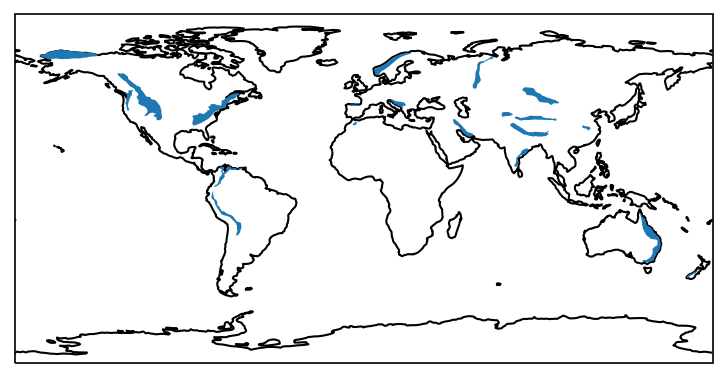

In [207]:
plt.figure(dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ids = []
for key, value in feature_mapping.items():
    sub_df = precip[precip["feature_code"]==key]
    for name, group in sub_df.groupby('place_name'):
        shp = value["shpfile"]
        sub_shp = shp[(shp["name"].str.lower()==name.lower())]
        if sub_shp.shape[0]>0:
            ax.add_geometries(sub_shp.geometry,ccrs.PlateCarree())
        else:
            print(name)
    #print(key)
    #print(sub_df.shape)